# Dimensionality reduction and noise removal of face images with Non-Negative Matrix Factorization


In [1]:
#Importing usefull libraries
import numpy as np
import matplotlib.pyplot as plt
# Required to import cv2 !!!
# %pip install opencv-python
import cv2
import pandas as pd
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import os
import time

def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

Non-negative Matrix Factorization (NMF) is a widely used algorithm commercially and in research. One attribute of the NMF is that it can be used to represent a matrix with a lower amount of data. Today, huge amounts of data are handled by companies, so a reduction in stored data gives the opportunity to reduce costs and increase storage efficiency. In the first part of the project we apply the NMF to a few smaller systems, so that we get to know the algorithm before applying it to larger sets of data. More specifically, when considering a large set of data, we are going to study how the NMF works with a collection of images. Finally, we will study how the NMF algorithm deals with images that have noise.

NMF is an algorithm used to represent a matrix $A$, but with a lower amount of data. The NMF-representation consists of two non-negative matrices $W$ and $H$, where the dot product between $W$ and $H$ gives an approximation to the original matrix. Combined, $W$ and $H$ has fewer components than $A$, and consequently holds lower amounts of data. If $A$ is a $m \times n$ matrix, $W$ and $H$ will consequently have dimensions $m \times d$ and $d\times n$ respectively.
Throughout this project we will experiment with the NMF algorithm, so that we can discuss its strengths and weaknesses. $d$ can be freely chosen, and later we will be testing the algorithm for different values of d, and investigate how this affects the the approximation. 

Before this we will prove and show a couple of NMF's properties. Firstly, lets prove that if the initial values of $W_0$ and $H_0$ are positive only gives non-negative updated values, when assuming that the input matrix A is non-negative.

<b>Induction</b>
1. 
    $W_0$ and $H_0$ are initialzed as positive, and A is assumed to be non-negative. \
    $\Rightarrow$ $W_0$ and $H_0$ are non-negative.
2. 
    Assume $W_k$ and $H_k$ are non-negative.
3. 
    Updates are given by:
    \begin{aligned}
        (H_{k+1})_{ij} \leftarrow & (H_k)_{ij} \cdot \frac{(W^T_k A)_{ij}}{(W^T_k W_k H_K)_{ij}} \\
        (W_{k+1})_{ij} \leftarrow & (W_k)_{ij} \cdot \frac{(A H^T_{k+1})_{ij}}{(W_k H_{k+1} H_{k+1}^T)_{ij}}
    \end{aligned}
    Since the matrix product of two non-negative matricies is also non-negative, every matrix product in the updates are non-negative, assuming that every factor is non-negative. \
    For $(H_{k+1})_{ij}$ every factor in every matrix product is assumed to be non-negative. Meaning the final product is something non-negative and non-negative. Meaning that $(H_{k+1})_{ij}$ must be non-negative. \
    The same logic works for $(W_{k+1})_{ij}$, since we now know that $(H_{k+1})_{ij}$ is also non-negative.

Therefore all iterates $W_{k}$ and $H_{k}$ are non-negative, by induction $\Box$.

Next lets prove that $H_k$ is fixed when $(W_k^T A) \oslash (W_k^T W_k H_k)=J_{m,n}$ is a matrix of ones.

Let $(W_k^T A) \oslash (W_k^T W_k H_k)=J_{m,n}$ be a matrix of ones.
\begin{aligned}
    & H_{k+1} \leftarrow H_k \odot (W^T_k A) \oslash (W^T_k W_k H_k) \\
    \Rightarrow & H_{k+1} \leftarrow H_k \odot J_{m,n} \\
    \Rightarrow &\underline{H_{k+1} \leftarrow H_k} \\
\end{aligned}
Therefore if $(W_k^T A) \oslash (W_k^T W_k H_k)=J_{m,n}$ is a matrix of ones, then $H_{k+1}=H_K$ and $H_k$ is a fixed point $\Box$.

Then lets show that this occures when $W_k H_k = A$.

Let $W_k H_k = A$.
\begin{aligned}
    (W_k^T A) \oslash (W_k^T W_k H_k) = (W_k^T A) \oslash (W_k^T A) = J_{m,n} \\
\end{aligned}
Therefore if $W_k H_k = A$, $(W_k^T A) \oslash (W_k^T W_k H_k)=J_{m,n}$ is a matrix of ones.

Combing these two facts shows that if the algorithm has converged (i.e. $W_k H_k = A$), it will not update the the matrices, and therefore will not begin to diverge after converging.

Finally we will show that we it is problematic to set the initial $W_0$ and $H_0$ to be matrices only containg zeros.

Let $W_0=0_{m,d}$ and $H_0=0_{d,n}$.
\begin{aligned}
    & H_{1} \leftarrow H_0 \odot (W^T_0 A) \oslash (W^T_0 W_0 H_0) \\
    \Rightarrow & H_{1} \leftarrow 0_{d,n} \odot (0_{d,m} A) \oslash (0_{d,m} 0_{m,d} 0_{d,n}) \\
    \Rightarrow & H_{1} \leftarrow 0_{d,n} \odot (0_{d,n}) \oslash (0_{d,n}) \\
\end{aligned}
This leads to being needed to calculate $0/0$, which is undefined. This is clearly problematic, and should be avoided.

Now that we know some basic properties of NMF, we now want to apply it to some basic matrices before using it on a real dataset. This is to get a basic understanding of what we expect to happen when we later will be using a more substantial dataset. For this purpose we use the following matrices: 


\begin{equation}
A1=
\begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}
, A2 = 
\begin{bmatrix}
1 & 2\\
1 & 1\\
1 & 2
\end{bmatrix}
\end{equation}


In [2]:
A1 = np.array([
    [1, 0],
    [0, 1]
])

A2 = np.array([
    [1, 2],
    [1, 1],
    [1, 2]
])

In [3]:
#implementing NMF nummerically
def NMF(V, d, delta = 1e-9, maxiter = 1000, seed = 0):
    """
    input:
        V: (m,n) input array
        d: integer, Number of components we want to decompose V into
        delta, float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
    output:
        W: (m,d) array
        H: (d,n) array
    """
    m, n = np.shape(V)

    if seed != 0:
        np.random.seed(seed)
    
    W0 = np.random.uniform(low=1e-20, high=1, size=m*d)
    H0 = np.random.uniform(low=1e-20, high=1, size=n*d)
    
    W0 *= np.sqrt(np.mean(V)/d)
    H0 *= np.sqrt(np.mean(V)/d)
    
    W0 = np.reshape(W0, (m, d))
    H0 = np.reshape(H0, (d, n))
    
    H_k = H0
    W_k = W0
    diff = np.zeros(maxiter)
    
    for k in range(maxiter):
        H_k = H_k*(np.dot(W_k.T, V))/(np.dot(np.dot(W_k.T, W_k), H_k)+ delta)
        W_k = W_k*(np.dot(V, H_k.T))/(np.dot(np.dot(W_k, H_k), H_k.T)+ delta)
        diff[k] = np.linalg.norm(V - np.dot(W_k, H_k))
    
    return W_k, H_k, diff

In [4]:
#Function that prints matrices in a more readable way
from IPython.display import display, Math

def print_matrix(array):
    data = ''
    for line in array:        
        if len(line) == 1:
            data += ' %.3f &'%line + r' \\\n'
            continue
        for element in line:
            data += ' %.3f &'%element
        data += r' \\' + '\n'
    display(Math('\\begin{bmatrix} \n%s\end{bmatrix}'%data))

In [5]:
print(f"d={1}\n")

W_A11, H_A11, diff = NMF(A1, 1, seed=1)
WH11 = np.dot(W_A11, H_A11)
diff_A11 = np.linalg.norm(A1 - WH11)
print(f"||A_1-WH||={diff_A11:.3e}, seed=1")

W_A12, H_A12, diff = NMF(A1, 1, seed=2)
WH12 = np.dot(W_A12, H_A12)
diff_A12 = np.linalg.norm(A1 - WH12)
print(f"||A_1-WH||={diff_A12:.3e}, seed=2")

W_A21, H_A21 , diff = NMF(A2, 1, seed =1)
WH21 = np.dot(W_A21, H_A21)
diff_A21 = np.linalg.norm(A2 - WH21)
print(f"||A_2-WH||={diff_A21:.3e}, seed=1")

W_A22, H_A22 , diff = NMF(A2, 1, seed =2)
WH22 = np.dot(W_A22, H_A22)
diff_A22 = np.linalg.norm(A2 - WH22)
print(f"||A_2-WH||={diff_A22:.3e}, seed=2")

d=1

||A_1-WH||=1.000e+00, seed=1
||A_1-WH||=1.000e+00, seed=2
||A_2-WH||=4.112e-01, seed=1
||A_2-WH||=4.112e-01, seed=2


First, we use the NMF with d = 1 on the matrices A1 and A2, we get:


Initial Matrix| Seed | W | H | WH | $$||A-WH||_F$$
:-------------------:|:---:|:---------------:|:---------------:|:---------------:|------------------------:
$\boldsymbol{A_1}$       |$1$| \begin{bmatrix}
                        0.295\\
                        0.509
                        \end{bmatrix}   | \begin{bmatrix}
                                                0.851 &
                                                1.470
                                            \end{bmatrix}  |\begin{bmatrix}
                                                                0.251 & 0.434\\
                                                                0.434 & 0.749
                                                                \end{bmatrix}|$1.000$
$\boldsymbol{A_1}$      |$2$|\begin{bmatrix}
                        0.308\\
                        0.018
                        \end{bmatrix}|\begin{bmatrix}
                                        3.232 &
                                        0.192
                                       \end{bmatrix}|\begin{bmatrix}
                                                        0.996 & 0.059\\
                                                        0.059 & 0.004
                                                        \end{bmatrix}|$1.000$
$\boldsymbol{A_2}$       |$1$|\begin{bmatrix}
                        0.722\\
                        0.441\\
                        0.722
                        \end{bmatrix}|\begin{bmatrix}
                                        1.524 &
                                        2.691
                                        \end{bmatrix}|\begin{bmatrix}
                                                           1.100 & 1.943\\
                                                           0.671 & 1.186\\
                                                           1.100 & 1.943
                                                            \end{bmatrix}|$0.411$
$\boldsymbol{A_2}$       |$2$|\begin{bmatrix}
                        0.457\\
                        0.279\\
                        0.457
                        \end{bmatrix}|\begin{bmatrix}
                                        2.405 &
                                        4.248
                                        \end{bmatrix}|\begin{bmatrix}
                                                        1.100 & 1.943 \\
                                                        0.671 & 1.186 \\
                                                        1.100 & 1.943
                                                        \end{bmatrix}|$0.411$

            

When comparing the results above, one would see that $\lVert A-WH \rVert_F$ is equal for both $A_1$ and $A_2$ both times. Even if the NMF gives different values to $W$ and $H$ for a specific matrix, the value $\lVert A-WH \rVert_F$ is unchanged. We know that the algorithm satisfies $\lVert A-W_{k+1}H_{k+1} \rVert \leq \lVert A-W_{k}H_{k} \rVert$. Consequently, the algorithm finds a local minimizer. Even though the algorithm returns different W and H for the different seeds, and that the resulting WH reconstructions are different, they both have converged to the same error value. This might imply that for this matrix and the number of iterations we use, always converges to the same error. Likely this means that it hits local minma which are all equivalent to the global minimum, even though every returned and reconstructed matrices are different. On the other hand, the A2 reconstruction converges to the same WH every time we run the NMF algorithm, even though the returned W and H matrices are different. Therefore it seems that the algorithm always hits the global error minima. In general it would be naive to assume that the error would be the same every run, and will likely not always hit the global error minimum.

To summarize, we get different W and H matrices every time we run the NMF algorithm, meaning a matrix $A$ has infinitely many approximations. This is shown for $A_1$, and by scaling the same can be said about $A_2$. Nevertheless, the discussion above also shows that some matrices, like A2, converge fast, resulting in a non-unique approximation WH. $\lVert A-WH \rVert_F$ is the only quantity we found to be non-unique for both A1 and A2.

Now let’s change the value of $d$ to 2, and see how that affects the matrices and error values:

In [6]:
print(f"d={2}\n")

W_A11, H_A11, diff = NMF(A1, 2, seed=1)
WH11 = np.dot(W_A11, H_A11)
diff_A11 = np.linalg.norm(A1 - WH11)
print(f"||A_1-WH||={diff_A11:.3e}, seed=1")

W_A12, H_A12, diff = NMF(A1, 2, seed=2)
WH12 = np.dot(W_A12, H_A12)
diff_A12 = np.linalg.norm(A1 - WH12)
print(f"||A_1-WH||={diff_A12:.3e}, seed=2")

W_A21, H_A21 , diff = NMF(A2, 2, seed =1)
WH21 = np.dot(W_A21, H_A21)
diff_A21 = np.linalg.norm(A2 - WH21)
print(f"||A_2-WH||={diff_A21:.3e}, seed=1")

W_A22, H_A22 , diff = NMF(A2, 2, seed =2)
WH22 = np.dot(W_A22, H_A22)
diff_A22 = np.linalg.norm(A2 - WH22)
print(f"||A_2-WH||={diff_A22:.3e}, seed=2")

d=2

||A_1-WH||=5.936e-10, seed=1
||A_1-WH||=5.546e-10, seed=2
||A_2-WH||=7.718e-10, seed=1
||A_2-WH||=9.605e-10, seed=2


Initial Matrix| Seed | W | H | WH | $$||A-WH||_F$$
:-------------------:|:---:|:---------------:|:---------------:|:---------------:|------------------------:
$\boldsymbol{A_1}$       |$1$|\begin{bmatrix}
                  0.380 & 0.\\
                  0. & 0.456\\
                \end{bmatrix}   |   \begin{bmatrix}
                                      2.632 & 0.\\
                                      0. & 2.193\\
                                    \end{bmatrix}  |\begin{bmatrix}
                                                      1. & 0.\\
                                                      0. & 1.\\
                                                    \end{bmatrix}|$5.936 \cdot 10^{-10}$
$\boldsymbol{A_1}$      |$2$|\begin{bmatrix}
                  0.472 & 0.\\
                  0. & 0.291\\
                \end{bmatrix}|  \begin{bmatrix}
                                  2.117 & 0.\\
                                  0. & 3.441\\
                                \end{bmatrix}|  \begin{bmatrix}
                                                  1. & 0.\\
                                                  0. & 1.\\
                                                \end{bmatrix}|$5.546 \cdot 10^{-10}$
$\boldsymbol{A_2}$      |$1$|\begin{bmatrix}
                  0.453 & 0.363\\
                  0. & 0.435\\
                  0.453 & 0.363\\
                \end{bmatrix}|  \begin{bmatrix}
                                  0.365 & 2.573\\
                                  2.300 & 2.300\\
                                \end{bmatrix}|  \begin{bmatrix}
                                                  1. & 2.\\
                                                  1. & 1.\\
                                                  1. & 2.\\
                                                \end{bmatrix}|$7.718 \cdot 10^{-10}$
$\boldsymbol{A_2}$      |$2$|\begin{bmatrix}
                  0.566 & 0.098\\
                  0.164 & 0.442\\
                  0.566 & 0.0976\\
                \end{bmatrix}|  \begin{bmatrix}
                                  1.470 & 3.357\\
                                  1.715 & 1.014\\
                                \end{bmatrix}|  \begin{bmatrix}
                                                  1. & 2.\\
                                                  1. & 1.\\
                                                  1. & 2.\\
                                                \end{bmatrix}|$9.605 \cdot 10^{-10}$

Here $WH$ for both matrices is almost exactly the same as $A$. This leads to $\lVert A-WH \rVert$ for $A_1$ and $A_2$ with $d=2$ to be in the range $1^{-10}$, which is approximately zero. This value of $d$ is big enough to not lose any information during the NMF, and the error could be due to the computers rounding error and lack of infinite decimalplaces. 

The rank of a given matrix is equal to the number of eigenvectors and therefore the number of free parameters the matrix has. A free parameter is in this context a linearly independent eigenvector. Both $A_1$ and $A_2$ are matrices with rank 2. The fact that NMF with $d$ equal to the rank gives a good approximation is likely not a coincidence. Let’s now define the matrices $A_3$ and $A_4$, which have both are $3 \times 3$, but with respectively rank 2 and 3.

\begin{equation}
A_3 = 
\begin{bmatrix}
2 & 1 & 1\\
2 & 1 & 1\\
1 & 1 & 2
\end{bmatrix}
, A_4 = 
\begin{bmatrix}
2 & 1 & 0\\
1 & 2 & 3\\
0 & 3 & 3
\end{bmatrix}
\end{equation}


In [7]:
A3 = np.array([
    [2, 1, 1],
    [2, 1, 1],
    [1, 1, 2]
])

A4 = np.array([
    [2, 1, 0],
    [1, 2, 3],
    [0, 3, 3]
])

In [8]:
print(f"A3 rank: {np.linalg.matrix_rank(A3)}\nA4 rank: {np.linalg.matrix_rank(A4)}")

A3 rank: 2
A4 rank: 3


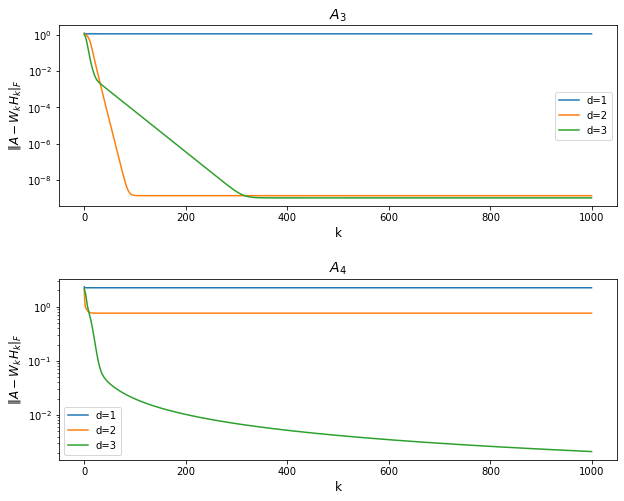

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)

for d in range(1, 4):
    W, H, diff = NMF(A3, d)
    ax1.semilogy(diff, label=f"d={d}")

ax1.set_title(r"$A_3$", size=14)
ax1.set_ylabel(r'$\Vert A - W_kH_k \vert_{F}$', size=12)
ax1.set_xlabel("k", size=12)
ax1.legend()
    
for d in range(1, 4):
    W, H, diff = NMF(A4, d)
    ax2.semilogy(diff, label=f"d={d}")

    
ax2.set_title(r"$A_4$", size=14)
ax2.set_ylabel(r'$\Vert A - W_kH_k \vert_{F}$', size=12)
ax2.set_xlabel("k", size=12)
ax2.legend()

plt.show()

For both of the matrices the $d=1$ approximation converges quite quickly, but the error is rather high compared to the two following d values. With $d=2$ converges quickly to an approximation with low error for the rank 2 matrix A3, which is promising for our earlier hunch. On the other hand the rank 3 matrix $A_4$ still converges quickly for $d=2$, but with a relatively higher error value. Finally with $d=3$ NMF most of the time converges even slower and the error is often worse than with $d=2$ with 1000 iterations for the rank 2 matrix $A_3$. On the other hand for the rank 3 matrix $A_4$ the error does not reach its local minima within 1000 iterations, but the error is substantially lower than for previous values of $d$.

Based on these qualitative findings, by using the rank of the matrix as the value of $d$ NMF converges quickly and gives a good approximation. This is likely because the rank is the number of free parameters needed to represent the matrix, and with $d=rank(A)$ the algorithm has just enough parameters to achieve this. Lower values of $d$ results in underfitting, since NMF no longer has enough parameters to reconstruct the matrix faithfully. This does not mean that lower values of $d$ should be disregarded, since the approximation can still be good and will take up less space than $d$ equal to the rank. On the other hand, values of $d$ larger than the rank will lead to overfitting, since NMF tries to represent the matrix with more parameters than it originally had, namely the rank of the matrix. Furthermore the algorithm will often converge slowly, which will result in the approximation returned often being worse than with $d$ equal to the rank. 

In order to verify our previous claims we will now apply NMF to a larger dataset.The dataset which will be used is 10 000 Cryptopunks NFTs. A Cryptopunk is a digital $24 \times 24$ RGBA image. Every Cryptopunk is algorithmically generated, meaning certain features such as cigarettes and hairstyles are shared between images. This means that the images more or less should be decomposable into image components, so that every image can be described as a sum of such components.

Before applying NMF we need to represent the data as a dimension 2 matrix. Firstly we randomly select 500 Cryptopunks from the pool of 10 000. This gives 500 $24 \times 24$ RGBA images. A natural way to store the images is to store them in a $24 \times 24 \times 4 \times 500$ array, i.e. 24 rows x 24 columns x 4 color channels x 500 images. We are going to assume the opacity to be known, and therefore discard the alpha channel, resulting in a $24 \times 24 \times 3 \times 500$ array. Finally to get the required dimension we reshape the array into the shape $1728 \times 500$ (i.e. $[24\cdot24\cdot3] \times 500$). This results in every image being represented as a vector with length 1728.  Below is a function which loads 500 randomly picked images from the dataset and stores them in an array as described. One thing to note is that the RGBA-values are divided by 255.0. This is to create an array of floats, with values between 0 and 1. The reason for this is to simplify the plotting of images.


In [17]:
def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N, integer, number of images to load
    Output:
        faces, (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
                
    return faces

# Number of faces to keep in final array
N = 500

# Load all 10000 images
faces = load_images(10000)

# Select N random images
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces = faces[:,:,:,choices]

# Check that the shape is correct
print(faces.shape)

(24, 24, 4, 500)


In [11]:
# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams

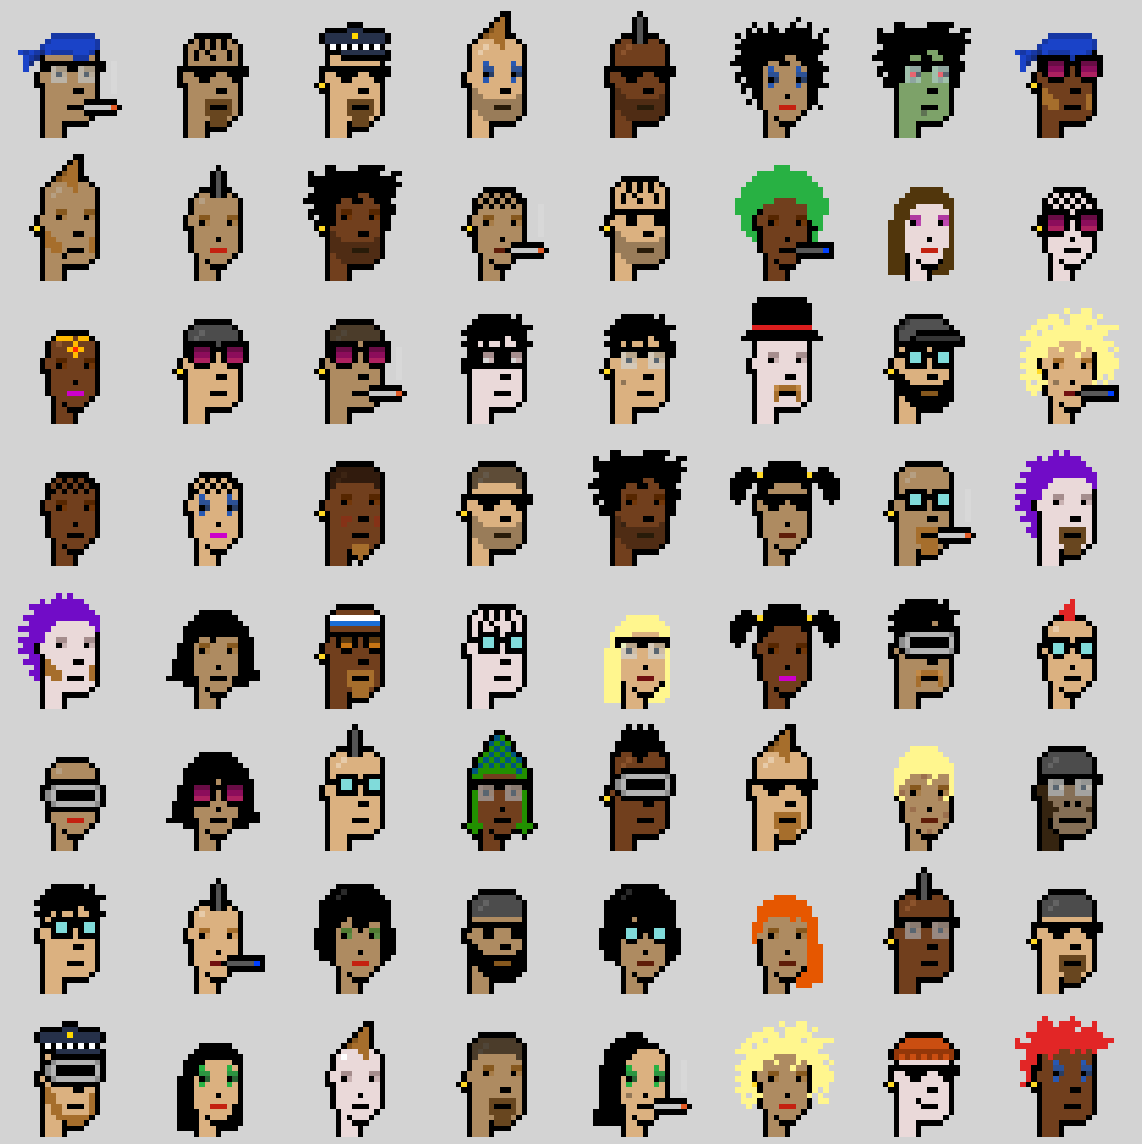

In [18]:
# Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
plotimgs(faces, 8, filename="punks.png")

Firstly, we want to find the mean of the $N=500$ images. Below is a plot of the mean:


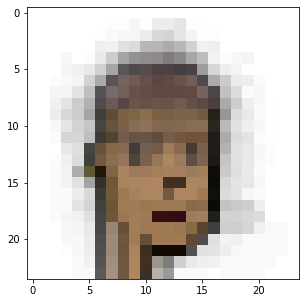

In [22]:
 # Split the images into opacity and rgb channels
faces_opacity = faces[:,:,3,:]
faces_rgb = faces[:,:,:3,:]
shape = faces_rgb.shape

# Clever reshape "trick". This is the matrix we will apply the NMF to
faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)
faces_opacity.shape

faces_mean = np.mean(faces, -1)

plt.figure(figsize = (5,5))
plt.imshow(faces_mean)
plt.show()

When examining the resulting image one can see that the pixels representing both the chin and the rightmost parts of the mean face are consistently the same shade of black. This can be explained by noticing that most of the images have the same contour defining the overall shape of the face, especially the rightmost part. On the other hand, other areas around the head have a light-gray shading. When examining the original images, one can see that there are a large variety of hats and hairstyles. This implies that we do not have a specific pattern repeating itself except the gray background, hence the gray shading in the mean plot. In summary, the mean plot tells us that some areas more than others have common features between all images, such as the overall head shape. Alternatively, areas that have a large variety of elements, like the top of the head or the eyes (i.e some have glasses) do not have a clear marking. 


Because certain characteristics are common in the images, we do not need unique vectors for all images. Rather, one can make the CryptoPunks as a sum of linear independent column or row vectors representing certain characteristics. When calculating the rank of the “faces'' matrix, we get the rank 380, meaning we can construct all $N=500$ images from 380 linear independent vectors. 

Furthermore, we want to see which characteristics the column vectors $W$ represents. The plotting is shown below:

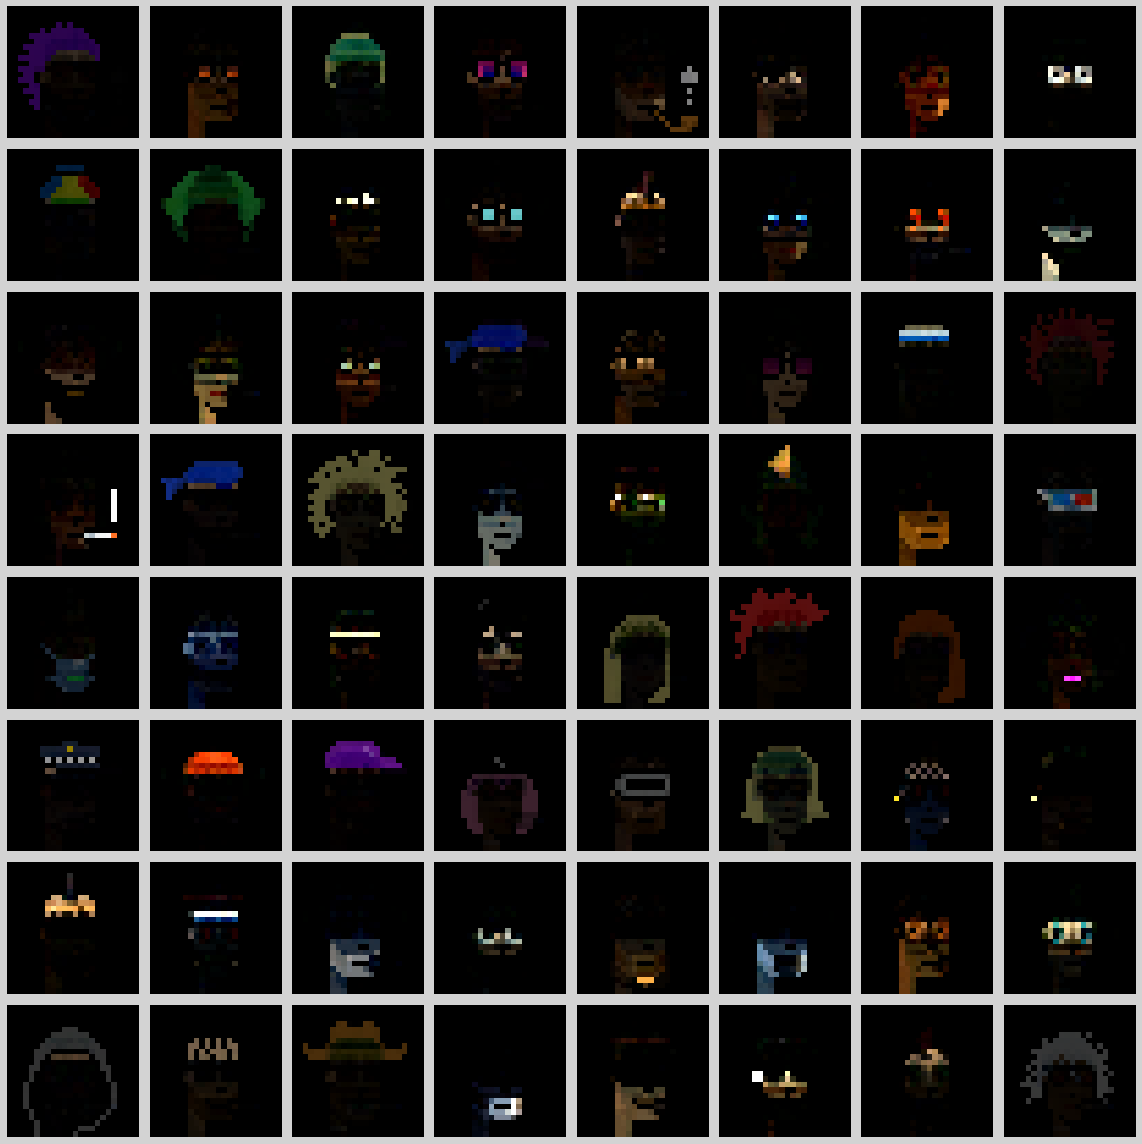

In [23]:
d = 64

W_k, H_k, diff = NMF(faces_reshaped, d)

W_k_reshape = W_k.reshape(24,24,3, d)
W_k_reshape[W_k_reshape>1] = 1 # får verdier som er større enn én, så gjør disse om til én

plotimgs(W_k_reshape, 8)

Firstly, one can see that many of the hats and hairstyles are still there, while most faces are gone. It looks like the characteristics that are not common in all images are the ones shown in the plotting. 

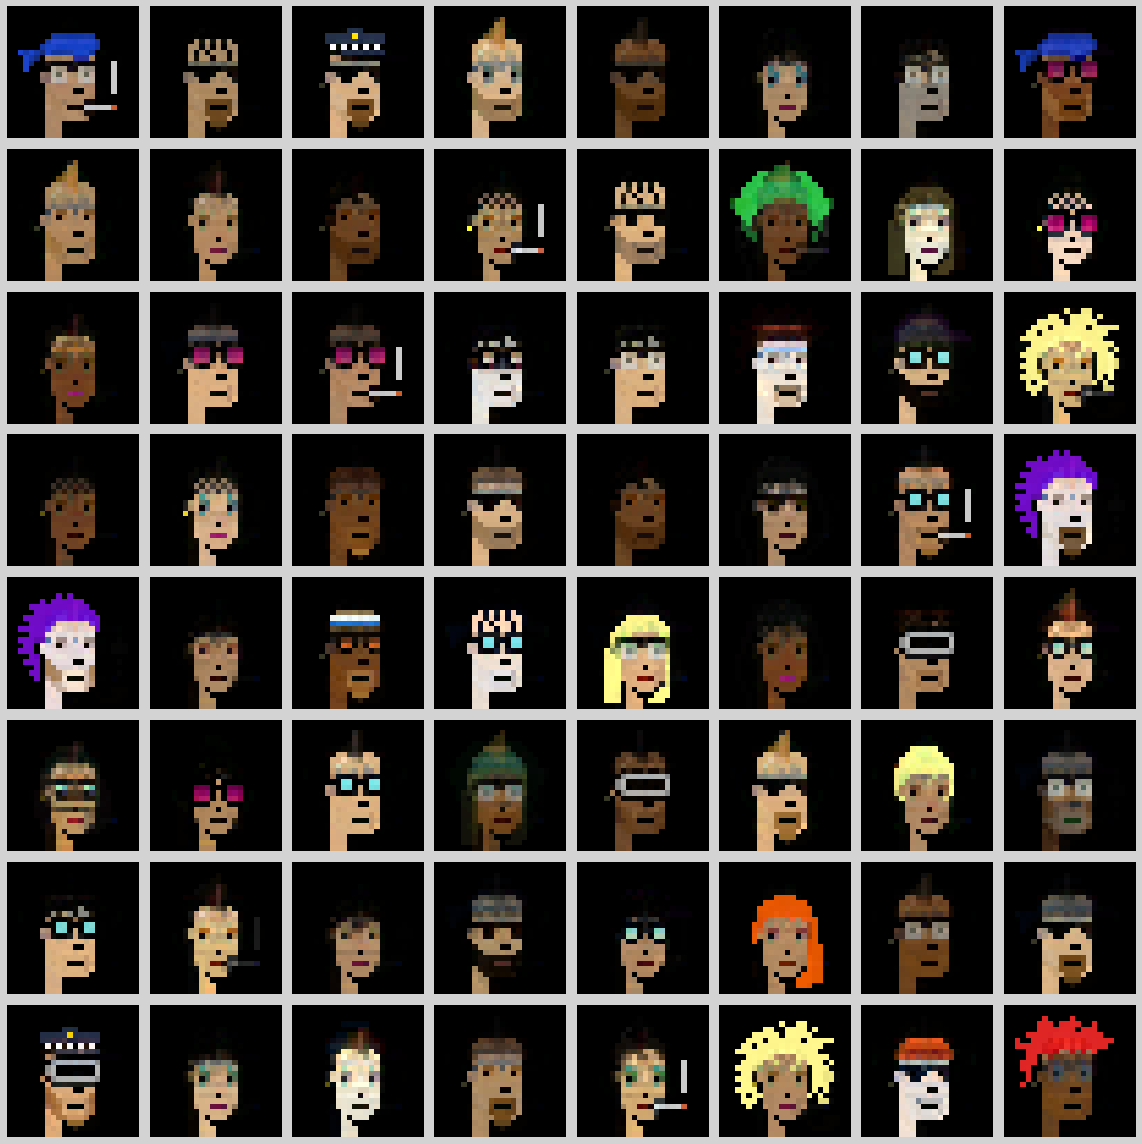

In [24]:
reconstruction = np.dot(W_k, H_k).reshape(24, 24, 3, 500)
reconstruction[reconstruction > 1] = 1

plotimgs(reconstruction, 8)

When plotting the NMF reconstruction, we combine the attributes that W and H holds to make up the whole CryptoPunk. However, one can notice that some areas, like the forehead and cheeks have a somewhat fuzzy pattern. Consequently, the algorithm struggles to reconstruct these areas. One reason could be that these areas have a lot of variety through all images, like different hairstyles, hats, beards and glasses. In other words, the algorithm struggles to find a specific pattern for these areas, making the reconstruction inaccurate. This is because the number of free parameters NMF has available to reconstruct the original is limited to $d=64$.

To show the difference between the original matrix and the reconstruction more clearly, we have plotted the difference of the images. The hue levels will represent the difference between the reconstruction and the original, with respectively darker and brighter hues indicating less and more error.

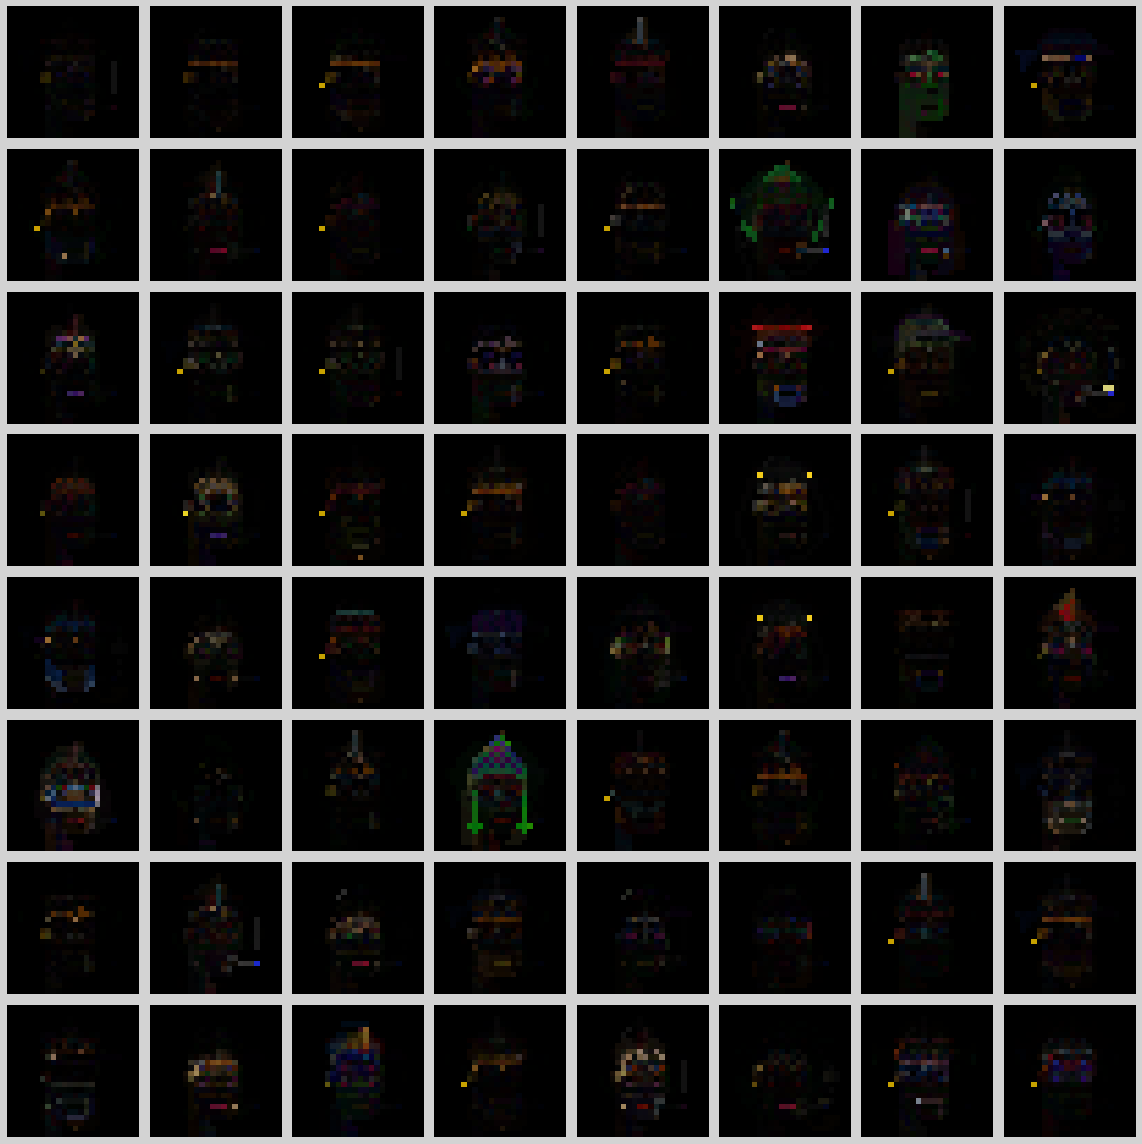

In [25]:
difference_matrix = reconstruction - faces_rgb

difference_matrix[difference_matrix > 1] = 1
# difference_matrix[difference_matrix < 0] = 0
difference_matrix = np.abs(difference_matrix)

plotimgs(difference_matrix, 8)

The above plot is mostly populated by black and other darker hues, indicating that the reconstruction is close to the original. One can also notice that it is mostly the top parts of the head which are the brightest. This fits with previous discussions that the top part of the head is the most prone to great variations between images. On the other side of the spectrum comes the features like the middle of the faces, larger hairstyles and the general head shape, which looks to be more or less black and therefore reconstructed accurately.

Furthermore, let’s evaluate how the algorithm converges, and to what degree with a couple of lower values of $d$ compared to $d=64$. Below is the error for $d = 16, 32, 64$ for every iteration:

Faces_reshaped rank: 362


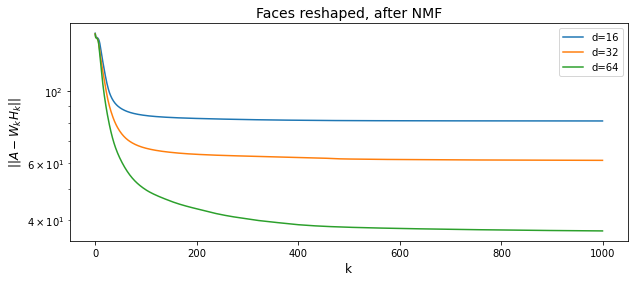

In [27]:
fig, ax = plt.subplots(figsize=(10, 4))
print(f"Faces_reshaped rank: {np.linalg.matrix_rank(faces_reshaped)}")


for d in (16, 32, 64):
    W, H, diff = NMF(faces_reshaped, d)
    ax.semilogy(diff, label=f"d={d}")

ax.set_title("Faces reshaped, after NMF", size=14)
ax.set_xlabel("k", size=12)
ax.set_ylabel(r"$||A-W_kH_k||$", size=12)
ax.legend()

plt.show()

For the different values of $d$, we can clearly see that the Frobenius Norm converges for every instance, with higher values converging slower. In return the error for the higher d values converges to lower error values.This as expected, since larger $d$ leads to more data getting stored in the new matrices. This is assuming that d is lower than the rank, which is clearly the case with 64 < ~350.  For example can the representation with $d=64$ possibly store all the colors of pixels of a hat, with $d=16$ only being able to recreate cruder and less specific features as seen below:

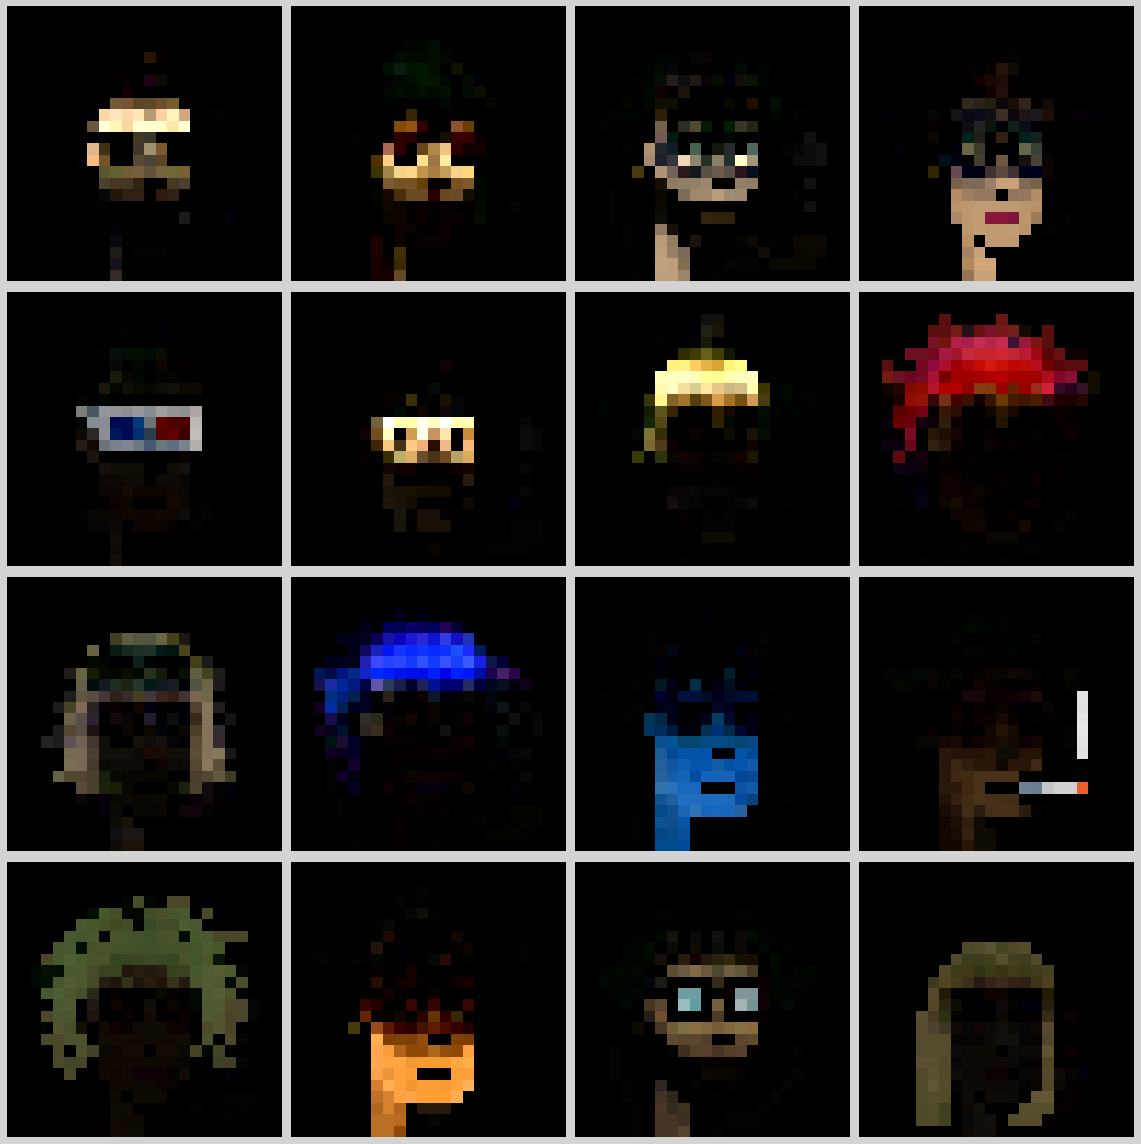

In [28]:
d = 16

W_k, H_k, diff = NMF(faces_reshaped, d)

W_k_reshape = W_k.reshape(24,24,3, d)
W_k_reshape[W_k_reshape>1] = 1 # får verdier som er større enn én, så gjør disse om til én

plotimgs(W_k_reshape, 4)

To further accentuate how larger values of d lead to less error, let’s plot the final error values as a function of $d$ for a large range of $d$:

8 : 98.62004146255897
16 : 79.97217523269562
24 : 67.27010514613086
32 : 59.99295321801043
64 : 36.25412782747549
96 : 25.192229709840095
128 : 19.38554633212054
192 : 12.019570447140081
256 : 8.880468134186389
384 : 5.330682129005241
512 : 3.7817848597357338


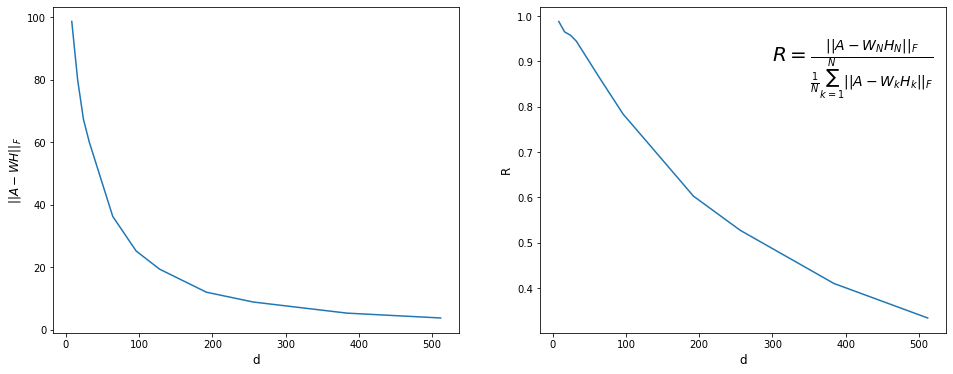

In [29]:
differences = np.zeros(11)
diff_mean = np.zeros_like(differences)
d_vals = np.zeros(11)
values = [8, 16, 24, 32, 64, 96 , 128, 192, 256, 384, 512]
for count, d in enumerate(values):
    W, H, diff = NMF(faces_reshaped, d)
    differences[count] = diff[-1]
    diff_mean[count] = np.mean(diff)
    d_vals[count] = d
    print(f'{d} : {diff[-1]}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plt.subplots_adjust(hspace=0.4)

ax1.plot(d_vals, differences)
ax1.set_xlabel('d', size=12)
ax1.set_ylabel(r'$||A - WH ||_{F}$', size=12)

ax2.plot(d_vals, differences/diff_mean)
ax2.set_xlabel('d', size=12)
ax2.set_ylabel("R", size=12)
ax2.text(300, 0.9, r'$R=\frac{||A-W_NH_N||_F}{\frac{1}{N} \sum_{k=1}^{N} || A - W_kH_k ||_{F}}$', size=20)

plt.show()

Firstly, the plotting shows that the error decreases as the value of $d$ increases, as expected by the previous discussion. The rank of the matrix is about 350-400. When examining the plotting one can see that the difference in error from this point on is small, meaning there is little to gain for larger values of $d$. Technically these values of d can lead to overfitting meaning it converges slower, as we have seen earlier. Even though the algorithm converges slower, we use enough iterations (1000) to reach a low error value. Another aspect to consider is the computational power. With a high value of $d$, there is a substantial difference in time it takes for the algorithm to finish. When considering a value of $d$, one should choose a value that gives a good representation of the data whilst not requiring considerable computational power and space.

So far we have worked with the images in a sterile noiseless environment, which is not often true in real world problems. Noise is unwanted modifications of signal, which is commonly found in most signal processing and indeed also in images. There are a variety of different reasons why noise occurs, but most physical noise behaves similarly to Gaussian distributions, and can be assumed to be independent of the original image. Therefore we will model noise as additive Gaussian noise given by $$A_{Noisy} = A + \sigma E$$, where $\sigma>0$ is a scalar noise level and E is a matrix with the same shape as A, with all components assumed to be given the by standard normal distribution. 

Similarly to previous discussion we are assuming that the opacity channel is known, and therefore assuming only the RGB channels to be noisy. In addition we will only be assuming there to be noise on non-zero pixels, and we will be clipping the values to lie between 0 and 1. This is to keep the images plottable.


In [30]:
def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = faces_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces

42.056914487288324


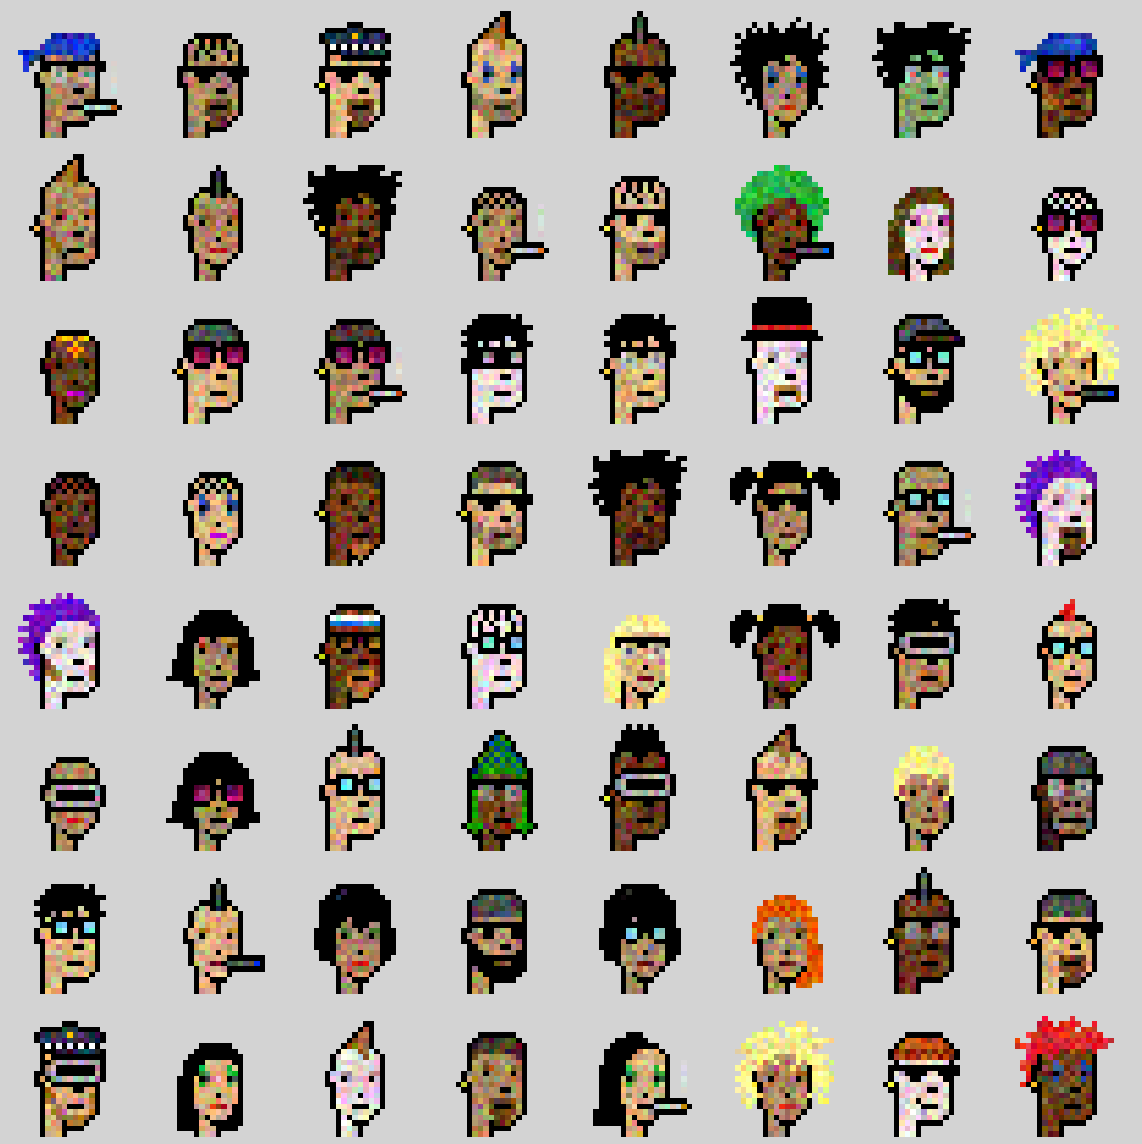

In [31]:
noisy_faces = add_noise(faces_reshaped, sigma = 0.1)

# Calculate the error of the noisy images
noise_residual = np.linalg.norm(noisy_faces - faces_reshaped)
print(noise_residual)

# For plotting noisy images we add the opacity
noisy_faces_with_opacity = np.zeros(faces.shape)
noisy_faces_with_opacity[:,:,:3,:] = noisy_faces.reshape(faces_rgb.shape)
noisy_faces_with_opacity[:,:,3,:] = faces_opacity
plotimgs(noisy_faces_with_opacity)

When we take a closer look at the CryptoPunks after adding noise, it is easy to see what effect is has had on them. Areas like the skin which had the same color, is now polluted with other colors in the original colors neighborhood. This has a big effect on the error between the noisy face and the original. Calculating the error $\lVert A_{noisy} − A \rVert_{F}$, we get a number that varies, depending on the inital 500 faces, around 40-42.

With noise being defined for this discussion, one of the true strengths of NMF can be highlighted. Namely its ability to denoise. If we interpret every column of W to be a mean of many noisy images with the same feature, one would expect the variance generated by the noise to be reduced when taking the mean, and therefore a reduction in noise is expected. One could argue noise itself to be a feature and therefore the algorithm would be prone to having eigenvectors dedicated to recreating it. The difference between noise and a true feature is that noise is random and without structure, and will therefore be harder to generalize and model for a wide array of images. 

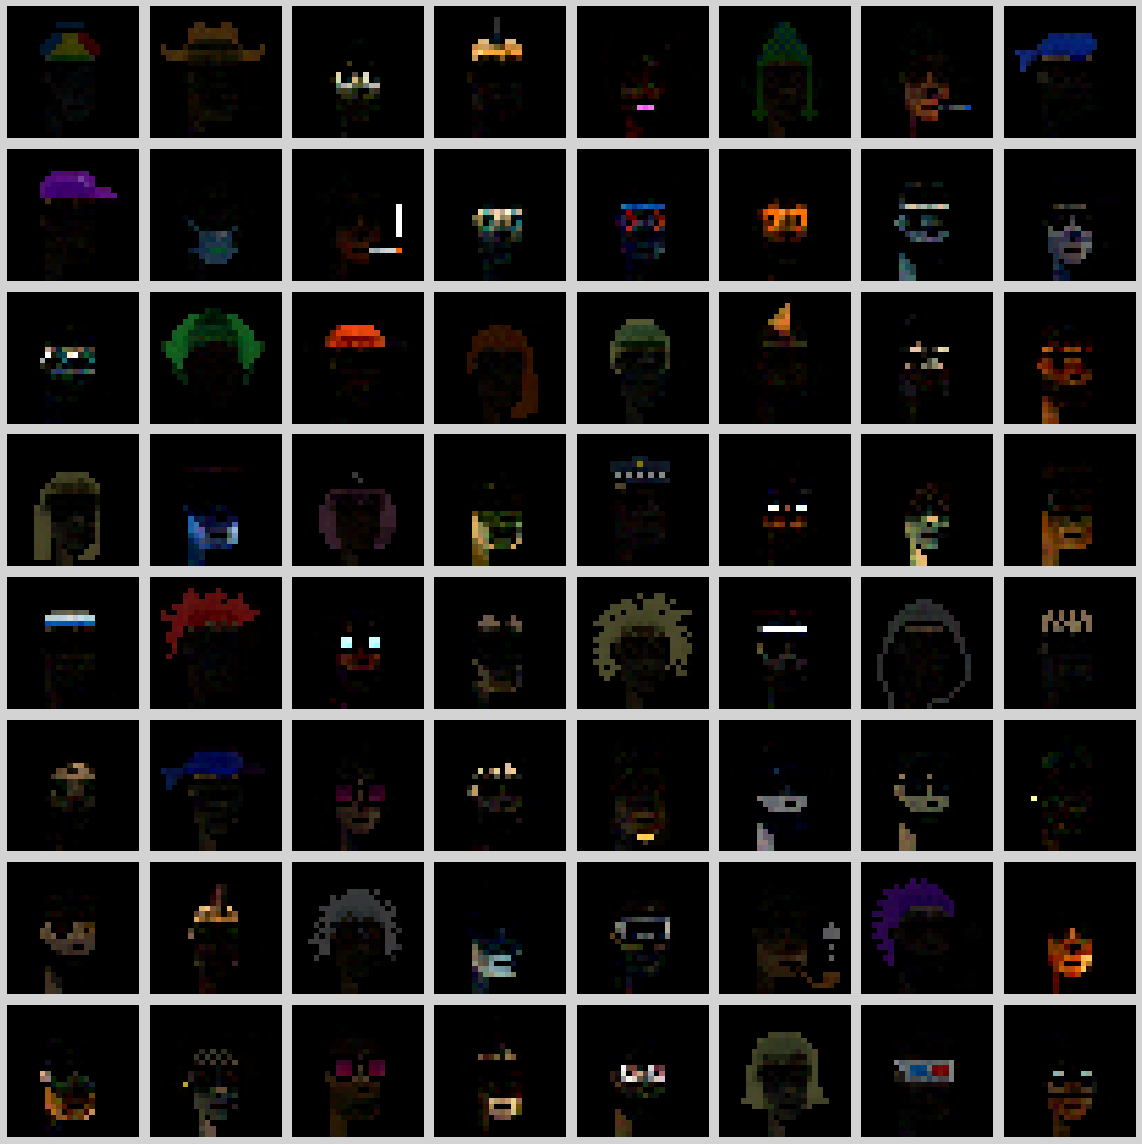

In [32]:
d = 64

W_k_Noisy, H_k_Noisy, diff = NMF(noisy_faces, d)

W_k_reshape = W_k_Noisy.reshape(24,24,3, d)
W_k_reshape[W_k_reshape>1] = 1 # får verdier som er større enn én, så gjør disse om til én

plotimgs(W_k_reshape, 8)

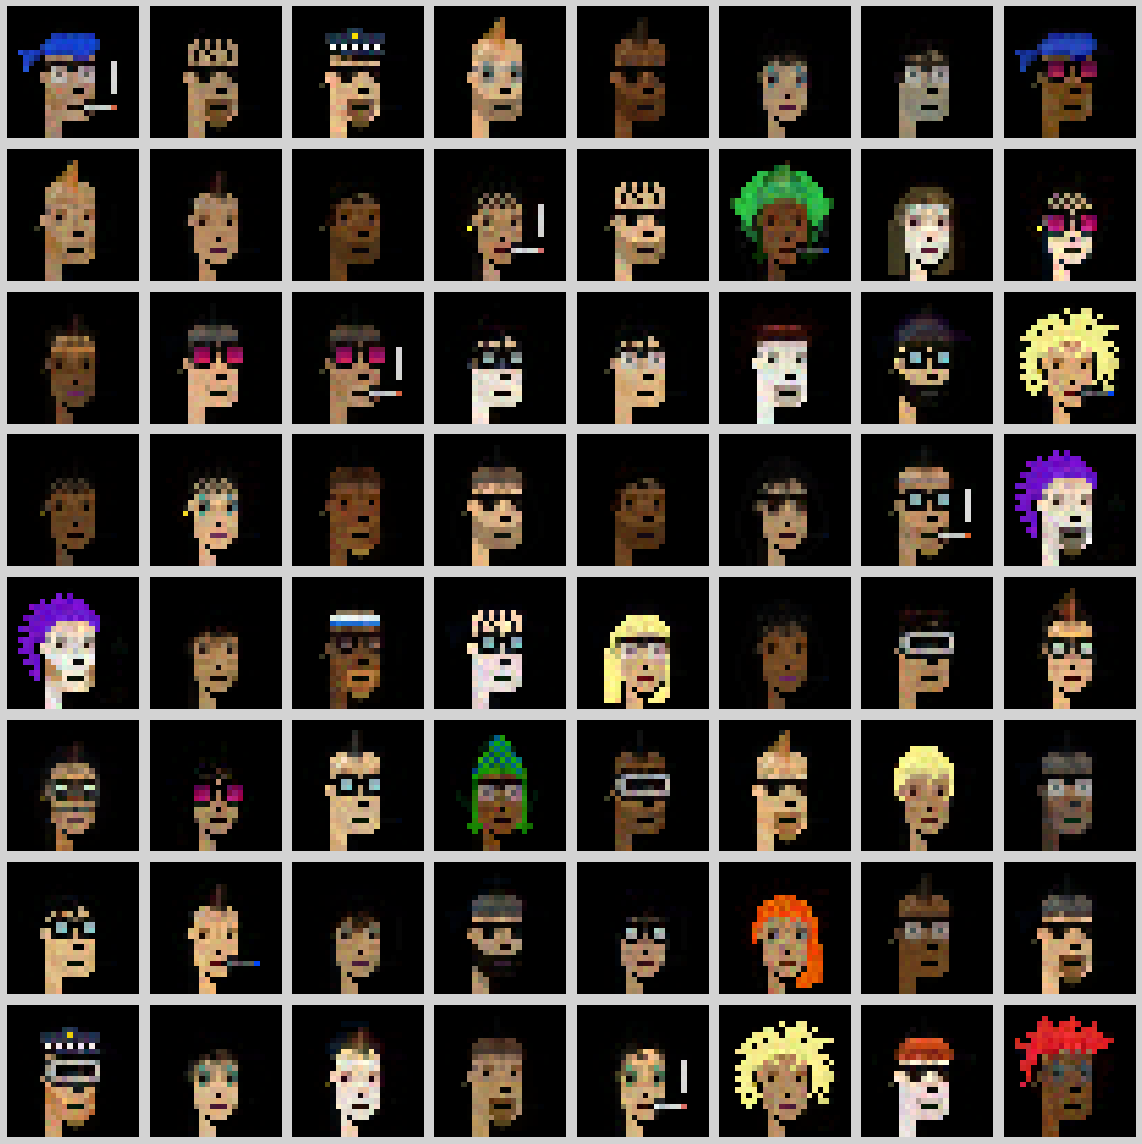

In [33]:
reconstruction1 = np.dot(W_k_Noisy, H_k_Noisy).reshape(24, 24, 3, 500)
reconstruction1[reconstruction1 > 1] = 1

plotimgs(reconstruction1, 8)

Now let’s see how the NMF reconstruction works with the noisy images, first with d=64. When plotting the columns of the noisy images, the result looks similar to the plot of W without noise. Even with noise, the algorithm picks up certain characteristics. Moreover, when plotting the NMF of the noisy images, we do not see too much of the noise. In spite of this, the noisy reconstruction seems to struggle to plot areas with low contrast. This is possible to see in the following plot: 

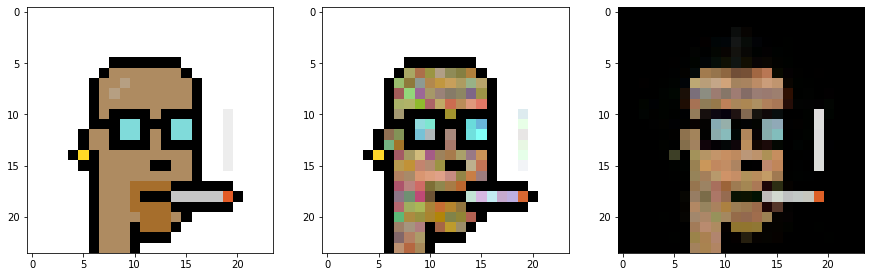

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
HL = 30

axes[0].imshow(faces[:,:,:, HL])
axes[1].imshow(noisy_faces_with_opacity[:,:,:,HL])
axes[2].imshow(reconstruction1[:,:,:, HL])
plt.show()

Looking at the noisy image before applying the NMF, the noise makes it hard to separate the CryptoPunk’s beard and skin tone because the contrast between these areas in the original is low. As a consequence, the beard of the reconstructed CryptoPunk is almost gone, faded into the skin tone. On the other hand, the cigarette is easily visible in all three images. The contrast between the CryptoPunk and the cigarette is clear, so that the NMF has no problem finding this element. 

This leads to a critical discussion into what value of d to choose. For the reconstruction of the images without noise, we saw that a higher d gives a better representation of the originals. On the other hand, if we choose a large value of d while considering the noise, the algorithm will be able to learn more of the noise, but with the image being recreated more faithfully (including the noise). Besides, with lower values of d the model will learn little of the noise, with the cost of the reconstruction being poor. Since higher values of d leads to overfitting with regards to the original matrix, the algorithm will have free parameters available to represent the noise. Therefore to best recreate the original images before the noise, we want to choose a value of d such that the algorithm doesn’t underfitting and without overfitting too much resulting in more noise being modeled. The rest of the rapport will focus on discussing what values of $d$ leads to a balance between under- and overfitting, i.e. trying to find a best fit.


8 : 9.800e+01
16 : 8.000e+01
24 : 7.100e+01
32 : 6.100e+01
64 : 4.000e+01
96 : 3.100e+01
128 : 2.800e+01
192 : 2.800e+01
256 : 3.000e+01
384 : 3.200e+01
512 : 3.400e+01


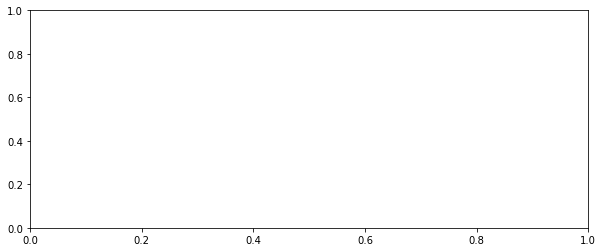

In [35]:
d_values = [8, 16, 24, 32, 64, 96, 128, 192, 256, 384, 512]
HL_face = np.zeros((24, 24, 3, len(d_values)))
error = np.zeros_like(d_values)

for i, d in enumerate(d_values):
    W, H, diff = NMF(noisy_faces, d)
    rec = (W @ H).reshape(24,24,3,500)
    rec[rec > 1] = 1
    HL_face[:,:,:,i] = rec[:,:,:,HL]
    error[i] = np.linalg.norm(faces_reshaped - W @ H)
    print(f'{d} : {error[i]:.3e}')

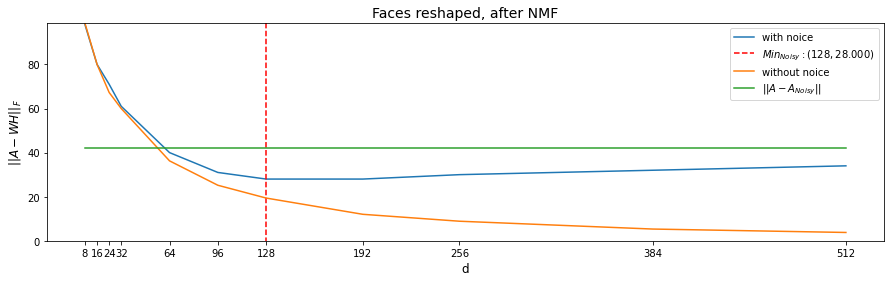

In [36]:
fig, ax = plt.subplots(figsize=(15, 4))

min_error = np.min(error)
min_index = np.argmin(error)

ax.plot(d_values, error, label="with noice")
ax.plot([d_values[min_index]]*2, [-1, max(np.max(error), np.max(differences))], "--r", label=r"$Min_{Noisy}:(%s, %.3f)$" % (d_values[min_index], min_error))
ax.plot(d_vals, differences, label="without noice")
ax.plot(d_vals, np.full_like(d_vals, np.linalg.norm(faces_reshaped - noisy_faces)), label=r"$||A-A_{Noisy}||$")
ax.set_title("Faces reshaped, after NMF", size=14)
ax.set_xlabel("d", size=12)
ax.set_ylabel(r"$||A-WH||_F$", size=12)
ax.set_ylim(0, max(np.max(error), np.max(differences)))
ax.set_xticks(d_values)
ax.legend()

plt.show()

Above are the final errors of the NMF algorithm with and without a noisy input matrix, with $d$ having values between 8 and 512. When $d$ is about less than 64 the error values follow eachother closely, with the error from the noisy input being slightly worse. After that point the error values start to diverge, with the error from the noisy input curving positively. results  in diminishing returns when increasing $d$, until the the error reaches a minimum value and thereafter starts to increase again. For different choices of images the minimum error value varies and is reached for different choices of $d$. In our testing with $\sigma=0.1$ the minimum value is reached with $d$ values ranging from 130 and 200.

As previously discussed, we reasoned that higher values of $d$ would result in the algorithm being more prone to interpret the noise as data and therefore try to approximate that aswell. This is the explanation for both the diminshing returns and the eventual increase in error when increasing $d$. Overfitting will be a fitting description for this behaviour, with the algorithm having enough parameters to be able to find and recreate the structure where there should be none.

On the other side of the spectrum, low $d$ values will result in poor reconstruction. When $d$ is lower than about 64, the noisy error is after the algorithm higher than it was before. This clearly underfitting, since afterwards the reconstructed matrix will have lower error than the noisy input. Doubly this shows that the algorithm is able to denoise the data.

Therefore to prevent both overfitting and underfitting we should choose a value of $d$ between lowest value of d which gave a overall lower error then before, and the $d$ which gives the minimum error value. In the above plots this range is given by $d \in [64, 192]$. The overall "best fit" will clearly be given by the d resulting in minimum error value. But when considering other factors such as data compression and run times, a lower value of d might be more adventageous. In the above plots, the "best fit" is given by $d=192$, but the difference in error between that and $d=128$ is almost negligible. 

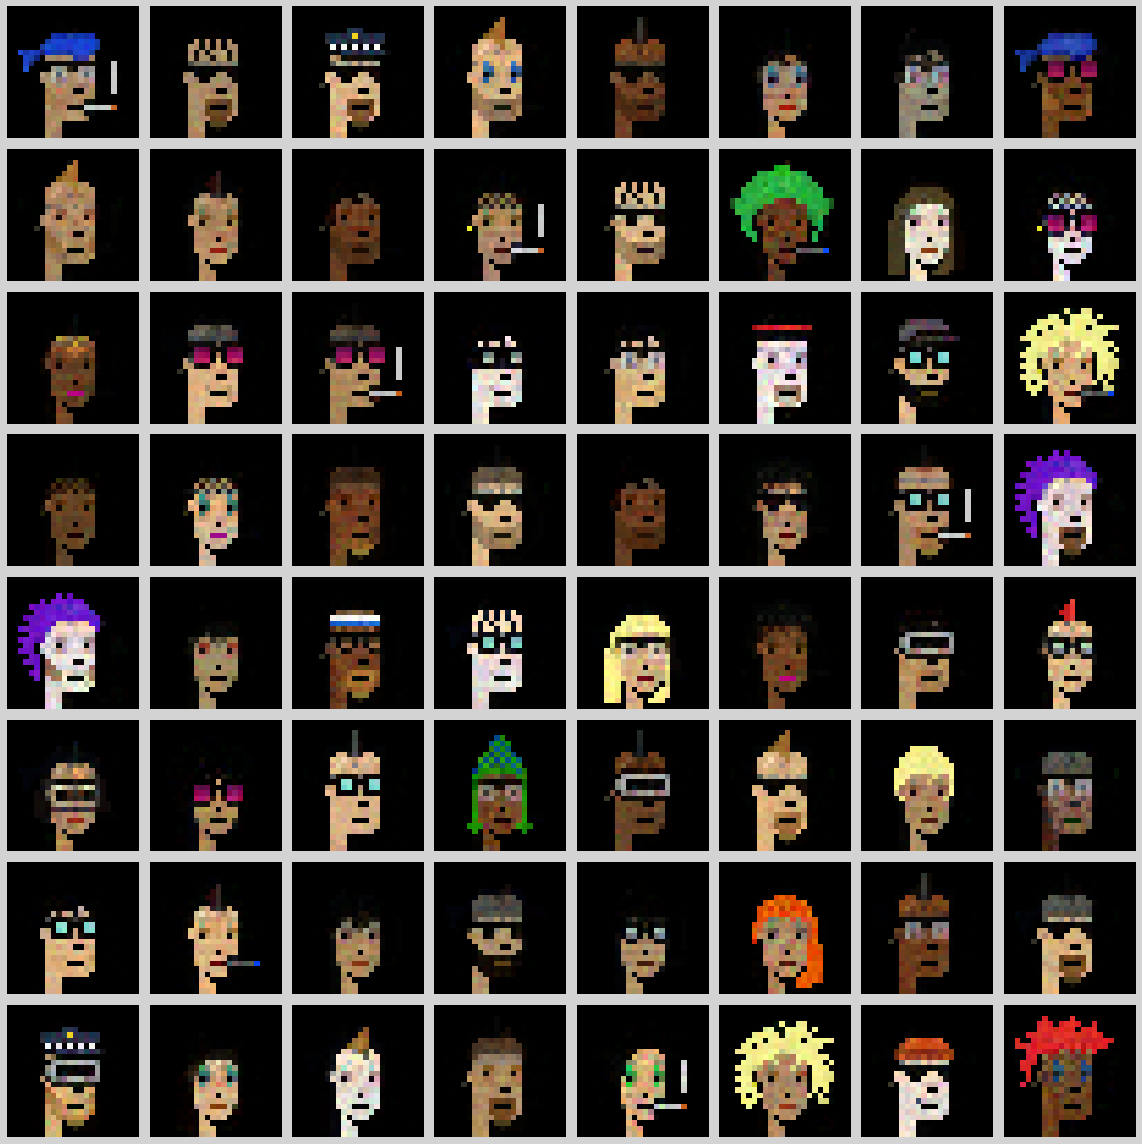

In [37]:
d = 100

W_k_Noisy, H_k_Noisy, diff = NMF(noisy_faces, d)

W_k_reshape = W_k_Noisy.reshape(24,24,3, d)
W_k_reshape[W_k_reshape>1] = 1 # får verdier som er større enn én, så gjør disse om til én


reconstruction2 = np.dot(W_k_Noisy, H_k_Noisy).reshape(24, 24, 3, 500)
reconstruction2[reconstruction2 > 1] = 1

plotimgs(reconstruction2, 8)

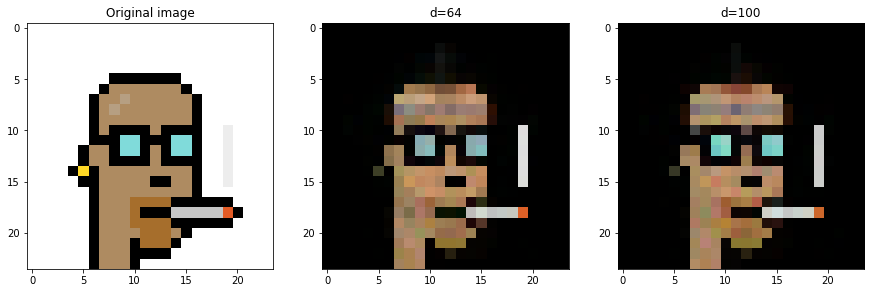

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(faces[:,:,:, HL])
axes[1].imshow(reconstruction1[:,:,:, HL])
axes[2].imshow(reconstruction2[:,:,:, HL])
axes[0].title.set_text("Original image")
axes[1].title.set_text("d=64")
axes[2].title.set_text("d=100")
plt.show()

Looking at the three different images above, it is apparent that the features with high contrast are the ones easiest recreated. The recreation for $d=64$ has recreated the glasses and cigarette very well, but struggles with the beard. With a $d$ closer to the optimal $d$, also the features with low contrast is reacreated well. 

Under is a animation of one face and its recreation, for every value of d we used earlier. This clearly shows that the general shape of the face is the first thing to be recreated. Later the more distinct features comes in focus, and gets better. Then the more vague features like beards are reconstructed closer to the original. For the biggest values for $d$, the unwanted noise that was added, appears again. The latter images is very similar, which resembles the flatting out of the plot

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 23), ylim=(23, 0))
data = HL_face
blank = np.zeros_like(data[:,:,:,0])
im = ax.imshow(blank)
txt = ax.text(11, -1,"", size=12)

def init():
    im.set_data(blank)
    txt.set_text("")
    return [im]
def animate(i):
    im.set_data(data[:,:,:,i])
    txt.set_text(f"d={d_values[i]}")
    return [im]

ani = FuncAnimation(fig, animate, init_func=init,
                               frames=data.shape[-1], interval=1000, blit=True)

HTML(ani.to_jshtml())
ani.save('./animation.gif', writer='imagemagick', fps=1)

In conclusion NMF can be a good tool for representing data with a lower amount of memory or storage. When choosing the value of $d$ one should consider runtime, how good approximation you need and data compression. Lower values of $d$ require less runtime and leads to less space usage, but lead to poorer data approximations and underfitting. Too high of a $d$ value requires more runtime and takes up more space, but depending on factors such as noise the data can be better approxmimated. However more is not always more, and one should be wary of overfitting, especially overfitting with regards to noise. By considering all of this, one can choose a value of $d$ which can denoise as a bonus to NMF's other benefits.

To conclude, NMF gives a good representation of data. As discussed, the model works best with the d value close to the rank or equal to the rank, as long as it does not require considerable computational power. For images without noise, a higher d value gives a better representation. In addition, the amount of data stored gets larger with d value, so one has to take this into consideration. This is important in cases with noisy images. Denoising is one of the true strengths of NMF, as it does not consider much of the noise for low values of d. With a relatively high d value, the recreation of the images actually becomes worse because both the error with respect to the original images without noise and the runtime increase. All this added up it is easy to see the benefits of using NMF, if it is used in the right situations.